<a href="https://colab.research.google.com/github/ronald-hk-chung/ComputerVision/blob/main/Fast_RCNN_implimentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implimenting Fast R-CNN for object detection

One of the major drawbacks of R-CNN is that it takes considerable time to generate predictions, as generating region proposals for each image, resizing the crops of regions, and extracting features corresponding to each crop (region proposal) constitute the bottleneck

Fast R-CNN gets around this problem by passing the entire image through the pretrained model to extract features and then fetching the region of features that correspond to the region proposals (which are obtained from `selectivesearch`) of the orginal image.

Below shows the major steps for Fast R-CNN

<center>
<br>
<img src="https://www.researchgate.net/publication/354679850/figure/fig2/AS:1069394021081088@1631974811453/Flow-chart-of-faster-R-CNN-model.png" width="500">
<br>
</center>

1. Pass the image through a pretrained model to extract features prior to the flattening layer (output as feature maps)

2. Extract region proposals corresponding to the image

3. Extract the feature map area corresponding to the region proposals (note that when an image is passed through a VGG16 architecture, the image is downscaled by 32 at the output as there are 5 pooling operations performed. Thus, if a region exists with a bounding box of (40, 32, 200, 240) in the original image, the feature map corresponding to the bounding box of (40, 32, 200, 240)/8 = (5, 4, 25, 30) would correspond to the exact same region)

4. Pass the feature maps corresponding to region proposals through the RoI Region of Interest) pooling layer one at a time so that all feature maps of region proposals have a similar shape. This is a replacement for the warping that was executed in the R-CNN technique

5. Pass the RoI pooling layer output value through a fully connected layer.

6. Train the model to predict the clas and offsets corresponding to each region proposal.

Note that the major difference between R-CNN and Fast R-CNN is that , in R-CNN, we are passing the crops (resized region proposals) through the pretrained model one at a time, while in Fast R-CNN, we rae cropping the feature map (which is obtained by passing the whole image through a pretrained model) corresponding to each region proposal and thereby avoiding the need to pass each resized region proposal through the pretained model



## Notebook Setup and import relevant libaries

In [1]:
!git clone https://github.com/ronald-hk-chung/TorchStep
!sh TorchStep/config.sh

Cloning into 'TorchStep'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 87 (delta 35), reused 76 (delta 24), pack-reused 0
Receiving objects: 100% (87/87), 21.56 KiB | 10.78 MiB/s, done.
Resolving deltas: 100% (35/35), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 49.3 MB/s eta 0:00:00


In [2]:
from torchvision import transforms, models, datasets
from torchvision.ops import nms
from torch.utils.data import Dataset, DataLoader
from torch import nn
from TorchStep.vision_utils import SelectiveSearch, show_image, extract_iou
from TorchStep.engine import TSEngine
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import cv2

## Download Dataset - Google Open Image v6 dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import shutil
from google.colab import files
files.upload() # upload kaggle.json
!ls -lha kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d sixhky/open-images-bus-trucks/
!unzip -qq open-images-bus-trucks.zip

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 69 Feb 12 11:28 kaggle.json
 94% 345M/367M [00:01<00:00, 266MB/s]
100% 367M/367M [00:01<00:00, 238MB/s]


## Preparing the dataset
1. Fetching each image and its corresponding class and bounding box values
2. Fetching the region proposals within each image, their corresponding IoU, and the delta by which the region proposal is to be corrected with respect to the ground truth
3. Assigning numeric lables for each class (where we have an additional background class *besides the bus and truck classes) where IoU with the ground thruth bounding box is below a threshold
4. Resizing each region proposal to a common size in order to pass them to a network

By the end, we will ahve resized crops of region proposals, along wiht assigning the ground truth class to each region proposal, and calculated the offset of the region proposal in relation to the ground truth bounding box

In [5]:
IMAGE_ROOT = 'images/images'
DF_RAW = pd.read_csv('df.csv')
DF_RAW.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,...,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,...,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,...,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,...,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,...,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452


`XMin`, `XMax`, `YMin`, `YMax` correspond to the ground truth of the bounding box of the image. `LabelName` provides the class of images

In [6]:
class OpenImages(Dataset):
  def __init__(self, df, image_folder):
    self.root = image_folder
    self.df = df
    self.unique_images = self.df['ImageID'].unique() #image can contain multiple objects
  def __len__(self):
    return len(self.unique_images)
  def __getitem__(self, idx):
    image_id = self.unique_images[idx]
    image_path = f'{self.root}/{image_id}.jpg'
    # image = cv2.imread(image_path, cv2.IMREAD_COLOR)[:,:,::-1]
    image = np.array(Image.open(image_path).convert('RGB'))
    h, w, _ = image.shape
    df = self.df[self.df['ImageID']==image_id]
    boxes = (df[['XMin','YMin', 'XMax', 'YMax']] * np.array([w, h, w, h])).astype(np.uint16).values.tolist()
    classes = df['LabelName'].values.tolist()
    return image, boxes, classes, image_path

ds = OpenImages(df=DF_RAW, image_folder=IMAGE_ROOT)

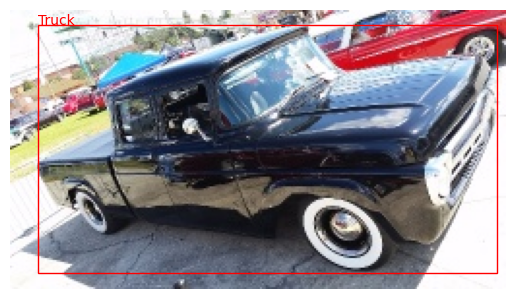

In [7]:
img, bbs, labels, path = ds[5]
show_image(img=img, bbs=bbs, bbs_label=labels, bbs_format='XYXY', color='r')

## Preparing region proposals and the ground truth of offset

Creating the input and output values correspond to R-CNN model:

- input constitutes the candidates that are extracted using the *Selective Search* using selectivesearch algo from `TorchStep.vision_utils.SelectiveSearch` (refer to https://github.com/ronald-hk-chung/ComputerVision/blob/main/selective_search_algo.ipynb)

- output constitutes the class corresponding to candidates and the offset of the candidate with respect to the bounding box it overlaps and most with if the candidate contains an object

In [8]:
data = []
N = 500
pbar = tqdm(total = N)
for ix, (im, bbs, labels, fpath) in enumerate(ds):
  if(ix==N):
      break
  # Extract candidates from each image in absolute pixel values
  H, W, _ = im.shape
  img_search = SelectiveSearch(img=im, scale=200, min_size=100)
  candidates = img_search.search(size_thresold=0.05, format='XYXY')

  # Initialise data_dict to hold ious, rois, clss and delta
  data_dict = {}
  rois, clss, deltas = [], [], []

  # Calculate ious comparing candidates to bbs (ground truth)
  ious = np.array([[extract_iou(candidate, bb) for candidate in candidates] for bb in bbs]).T

  for jx, candidate in enumerate(candidates):
    cx1,cy1,cx2,cy2 = candidate
    candidate_ious = ious[jx] # Get candidate ious
    # Find the index of candidate that has the highest IoU and correponding gound truth (best_bb)
    best_iou_index = np.argmax(candidate_ious)
    best_iou = candidate_ious[best_iou_index]
    best_bb = x1, y1, x2, y2 = bbs[best_iou_index]
    # If IoU (best_iou) is grater than a thresold(0.3), assign label of class, otherwise assign 'background'
    clss.append(labels[best_iou_index]) if best_iou > 0.3 else clss.append('Background')
    # Fetch offset needed (deltas) to transform current proposal into the candidate that is the best region proposal (best_bb)
    delta = np.array([x1-cx1, y1-cy1, x2-cx2, y2-cy2]) / np.array([W,H,W,H])
    deltas.append(delta)
    rois.append(candidate / np.array([W,H,W,H]))

  # put fpath, ious, rois, clss, deltas and bbs(as gtbbs) in data_dict and append to data
  data_dict['fpaths'] = fpath
  data_dict['ious'] = ious # intersection of unions result
  data_dict['rois'] = rois # regional proposal locations
  data_dict['clss'] = clss # class of bounding box
  data_dict['deltas'] = deltas # offset of ground_truth bounding box - candidate bounding box relative to image size
  data_dict['gtbbs'] = bbs # ground truth bounding box
  data.append(data_dict)
  pbar.update(1)
pbar.close()

In [8]:
import pickle
with open('drive/MyDrive/CV/rcnn_data.pkl', 'rb') as f:
  data = pickle.load(f)

In [9]:
# Convert clss into their corresponding indices
# background 0, Bus 1, Truck 2
classes = sorted(set([item for data_dict in data for item in data_dict['clss']]))
label2target = {k : v for v, k in enumerate(classes)}
target2label = {v : k for k, v in label2target.items()}
print(label2target)
print(target2label)

{'Background': 0, 'Bus': 1, 'Truck': 2}
{0: 'Background', 1: 'Bus', 2: 'Truck'}


In [ ]:
# # # savedown data into rcnn_data.pt
# import pickle
# with open('drive/MyDrive/CV/rcnn_data.pkl', 'wb') as f:
#   pickle.dump(data, f)

## Define FRCNNDataset class that returns images, labels, ground truths, region proposals and delta corresponding to each region proposal:

In [10]:
import torch
from torchvision.transforms import v2 as T
tf = T.Compose([T.ToImage(),
                T.ToDtype(torch.float32, scale=True),
                T.Resize(size=(224, 224), antialias=True),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)])

In [11]:
class FRCNNDataset(Dataset):
  def __init__(self, data):
    self.data = data
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    fpath = self.data[idx]['fpaths']
    # image = cv2.imread(fpath, cv2.IMREAD_COLOR)[:,:,::-1]
    image = np.array(Image.open(fpath).convert('RGB'))
    rois = self.data[idx]['rois']
    gtbbs = self.data[idx]['gtbbs']
    labels = self.data[idx]['clss']
    deltas = self.data[idx]['deltas']
    return image, rois, labels, deltas, gtbbs, fpath
  def collate_fn(self, batch):
    input = []
    rois = []
    rixs = []
    labels = []
    deltas = []
    for idx in range(len(batch)):
      image, image_rois, image_labels, image_deltas, image_gtbbs, image_fpath = batch[idx]
      input += [tf(image)]
      rois += image_rois  # holds information regarding RoI of image
      rixs += [idx] * len(image_rois) # holds information regarding the RoI of which images in format of [0, 0, 1, 1, 1]
      labels += [label2target[c] for c in image_labels]
      deltas += image_deltas
    input = torch.stack(input, dim=0)
    rois = torch.Tensor(np.array(rois)).float()
    rixs = torch.Tensor(np.array(rixs)).float()
    labels = torch.Tensor(np.array(labels)).long()
    deltas = torch.Tensor(np.array(deltas)).float()
    return (input, rois, rixs), labels, deltas

Major difference between FRCNN and RCNN in the dataset is roi sand rixs. The rois matrix holds information regarding which RoI belongs to which image in the batch. Note that input contains multiple images, whereas rois is a single list of boxes. To distinguish how many rois belong to each image, rixs is used which is a list of indices. Each integer int he list associate the corrresponding bouding box with the appropaite image in the format of [0, 0, 0 , 1, 1 ...].

## Creating train and valid dataloader

In [12]:
from sklearn.model_selection import train_test_split
data_train, data_valid = train_test_split(data, test_size=0.1)

train_ds = FRCNNDataset(data=data_train)
valid_ds = FRCNNDataset(data=data_valid)

train_dl = DataLoader(dataset=train_ds,
                      batch_size=2,
                      collate_fn=train_ds.collate_fn,
                      shuffle=True,
                      drop_last=True)

valid_dl = DataLoader(dataset=valid_ds,
                      batch_size=2,
                      collate_fn=valid_ds.collate_fn,
                      shuffle=False,
                      drop_last=True)

## Define model to train on the dataset

In [13]:
# Get pretrained vgg16_bn
from TorchStep.vision_utils import get_pretrained_model
vgg, tfms, rtfms = get_pretrained_model(name='vgg16_bn', pretrained_weights='VGG16_BN_Weights.IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:03<00:00, 140MB/s] 


In [14]:
# Import RoIPool from torchvision.ops
from torchvision.ops import RoIPool

### RoIPooling in Object Detection: PyTorch Implementation(with CUDA)

Region of interest pooling (also known as RoI pooling) is an operation widely used in object detection tasks using convolutional neural networks. For example, to detect multiple cars and pedestrians in a single image. Its purpose is to perform max pooling on inputs of nonuniform sizes to obtain fixed-size feature maps (e.g. 7×7).

The layer takes two inputs:

1. A fixed-size feature map obtained from a deep convolutional network with several convolutions and max pooling layers.
2. An N x 5 matrix of representing a list of regions of interest, where N is a number of RoIs. The first column represents the image index and the remaining four are the coordinates of the top left and bottom right corners of the region.

For every region of interest from the input list, it takes a section of the input feature map that corresponds to it and scales it to some pre-defined size (e.g., 7×7). The scaling is done by:

1. Dividing the region proposal into equal-sized sections (the number of which is the same as the dimension of the output)
2. Finding the largest value in each section
3. Copying these max values to the output buffer

<img src='https://i.imgur.com/0SLzdKU.gif'>

In [15]:
class FRCNN(nn.Module):
  def __init__(self):
    super().__init__()
    feature_dim = 512*7*7
    self.backbone = nn.Sequential(*list(vgg.children())[:-1])
    self.roipool = RoIPool(output_size=7, # the size of the output after the cropping is performed, as (height, width)
                           spatial_scale=14/224) # a scaling factor that maps the box coordinates to the input coordinates
    self.cls_score = nn.Linear(feature_dim, len(label2target))
    self.bbox = nn.Sequential(nn.Linear(feature_dim, 512),
                              nn.ReLU(),
                              nn.Linear(512, 4),
                              nn.Tanh())
  def forward(self, *X):
    input, rois, ridx = X
    res = self.backbone(input)
    # 1st column represents the image index
    # remaining four are the coordinates of the top left and bottom right corners of the region
    rois = torch.cat([ridx.unsqueeze(-1), rois*224], dim=-1)
    res = self.roipool(res, rois) # extract small feature map from each RoI in detection
    feat = torch.flatten(res, 1)
    cls_score = self.cls_score(feat)
    bbox = self.bbox(feat)
    return cls_score, bbox

frcnn = FRCNN()

In [16]:
class RCNNLoss:
  def __init__(self):
    self.detection_loss = nn.CrossEntropyLoss()
    self.regression_loss = nn.L1Loss()
  def __call__(self, y_logits, y):
    detection_loss = self.detection_loss(y_logits[0], y[0])
    ixs = torch.where(y[0] != 0)
    if len(ixs) > 0:
      regression_loss = self.regression_loss(y_logits[1][ixs], y[1][ixs])
      if torch.isnan(regression_loss):
        regression_loss = 0
    else:
      regression_loss = 0
    return detection_loss + 10 * regression_loss

loss_fn = RCNNLoss()

In [17]:
class RCNNMetric:
  def __init__(self):
    self.detection_loss = nn.CrossEntropyLoss()
    self.regression_loss = nn.L1Loss()
  def __call__(self, y_logits, y):
    detection_loss = self.detection_loss(y_logits[0], y[0]).cpu().detach().numpy()
    detection_acc = sum(y_logits[0].argmax(dim=1) == y[0]).item() / len(y[0])
    ixs = torch.where(y[0] != 0)
    if len(ixs) > 0:
      regression_loss = self.regression_loss(y_logits[1][ixs], y[1][ixs]).cpu().detach().numpy()
      if np.isnan(regression_loss):
        regression_loss = 0
    else:
      regression_loss = 0
    return detection_loss, detection_acc, (0 if np.isnan(regression_loss) else regression_loss)

metric_fn = RCNNMetric()

In [18]:
FRCNNDetector = TSEngine(model=frcnn,
                         optim=(torch.optim.SGD, {'lr': 1e-3}),
                         loss_fn=loss_fn,
                         metric_fn=metric_fn,
                         train_dataloader=train_dl,
                         valid_dataloader=valid_dl)

In [19]:
FRCNNDetector.freeze(['backbone'])

In [20]:
FRCNNDetector.model_info()

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
FRCNN (FRCNN)                            [2, 3, 224, 224]     [83, 3]              --                   Partial
├─Sequential (backbone)                  [2, 3, 224, 224]     [2, 512, 7, 7]       --                   False
│    └─Sequential (0)                    [2, 3, 224, 224]     [2, 512, 7, 7]       --                   False
│    │    └─Conv2d (0)                   [2, 3, 224, 224]     [2, 64, 224, 224]    (1,792)              False
│    │    └─BatchNorm2d (1)              [2, 64, 224, 224]    [2, 64, 224, 224]    (128)                False
│    │    └─ReLU (2)                     [2, 64, 224, 224]    [2, 64, 224, 224]    --                   --
│    │    └─Conv2d (3)                   [2, 64, 224, 224]    [2, 64, 224, 224]    (36,928)             False
│    │    └─BatchNorm2d (4)              [2, 64, 224, 224]    [2, 64, 224, 224]    (128)                False
│    │ 

In [21]:
FRCNNDetector.train(15)

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Train Step:   0%|          | 0/225 [00:00<?, ?it/s]

Valid Step:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | LR: 1.0E-03 | train_loss: 2.073 | valid_loss: 2.087 | train_metric: [0.957 0.685 0.112] | valid_metric: [0.919 0.754 0.117] 


Train Step:   0%|          | 0/225 [00:00<?, ?it/s]

Valid Step:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 2 | LR: 1.0E-03 | train_loss: 1.862 | valid_loss: 1.885 | train_metric: [0.891 0.714 0.097] | valid_metric: [0.878 0.748 0.101] 


Train Step:   0%|          | 0/225 [00:00<?, ?it/s]

Valid Step:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 3 | LR: 1.0E-03 | train_loss: 1.752 | valid_loss: 1.915 | train_metric: [0.849 0.736 0.09 ] | valid_metric: [0.855 0.757 0.106] 


Train Step:   0%|          | 0/225 [00:00<?, ?it/s]

Valid Step:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 4 | LR: 1.0E-03 | train_loss: 1.658 | valid_loss: 1.838 | train_metric: [0.816 0.75  0.084] | valid_metric: [0.844 0.758 0.099] 


Train Step:   0%|          | 0/225 [00:00<?, ?it/s]

Valid Step:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 5 | LR: 1.0E-03 | train_loss: 1.611 | valid_loss: 1.795 | train_metric: [0.796 0.755 0.081] | valid_metric: [0.805 0.776 0.099] 


Train Step:   0%|          | 0/225 [00:00<?, ?it/s]

Valid Step:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 6 | LR: 1.0E-03 | train_loss: 1.551 | valid_loss: 1.764 | train_metric: [0.767 0.764 0.078] | valid_metric: [0.793 0.765 0.097] 


Train Step:   0%|          | 0/225 [00:00<?, ?it/s]

Valid Step:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 7 | LR: 1.0E-03 | train_loss: 1.503 | valid_loss: 1.69 | train_metric: [0.749 0.768 0.075] | valid_metric: [0.779 0.763 0.091] 


Train Step:   0%|          | 0/225 [00:00<?, ?it/s]

Valid Step:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 8 | LR: 1.0E-03 | train_loss: 1.468 | valid_loss: 1.789 | train_metric: [0.732 0.774 0.074] | valid_metric: [0.774 0.77  0.101] 


Train Step:   0%|          | 0/225 [00:00<?, ?it/s]

Valid Step:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 9 | LR: 1.0E-03 | train_loss: 1.431 | valid_loss: 1.721 | train_metric: [0.715 0.773 0.072] | valid_metric: [0.767 0.773 0.095] 


Train Step:   0%|          | 0/225 [00:00<?, ?it/s]

Valid Step:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 10 | LR: 1.0E-03 | train_loss: 1.39 | valid_loss: 1.758 | train_metric: [0.701 0.78  0.069] | valid_metric: [0.764 0.772 0.099] 


Train Step:   0%|          | 0/225 [00:00<?, ?it/s]

Valid Step:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 11 | LR: 1.0E-03 | train_loss: 1.359 | valid_loss: 1.7 | train_metric: [0.685 0.785 0.067] | valid_metric: [0.748 0.772 0.095] 


Train Step:   0%|          | 0/225 [00:00<?, ?it/s]

Valid Step:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 12 | LR: 1.0E-03 | train_loss: 1.34 | valid_loss: 1.752 | train_metric: [0.673 0.789 0.067] | valid_metric: [0.768 0.766 0.098] 


Train Step:   0%|          | 0/225 [00:00<?, ?it/s]

Valid Step:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 13 | LR: 1.0E-03 | train_loss: 1.313 | valid_loss: 1.64 | train_metric: [0.664 0.786 0.065] | valid_metric: [0.721 0.775 0.092] 


Train Step:   0%|          | 0/225 [00:00<?, ?it/s]

Valid Step:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 14 | LR: 1.0E-03 | train_loss: 1.299 | valid_loss: 1.754 | train_metric: [0.649 0.794 0.065] | valid_metric: [0.764 0.771 0.099] 


Train Step:   0%|          | 0/225 [00:00<?, ?it/s]

Valid Step:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 15 | LR: 1.0E-03 | train_loss: 1.273 | valid_loss: 1.679 | train_metric: [0.635 0.799 0.064] | valid_metric: [0.715 0.776 0.096] 


## Predict on an new image

1. Obtain region proposals and conver tthem to (x1, y1, x2, y2) format (top-left pixel and bottom-right pixel coordinates), and then convert these values to the ratio of the width and height they are present in proportion to the image

2. Preprocess the image and scale the region of interests (rois)

3. As all proposals belong to the same image, rixs will be a list of zeros (as many as the number of proposals)

4. Forward propagate the input and rois through the trained model and get confidences and class scores for each proposal

5. Filter out the background class

6. Plot the bounding boxes obtained

In [24]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from torchvision.ops import nms
from PIL import Image

def frcnn_inference(fname: str):
  img = Image.open(fname).convert('RGB')

  img_search = SelectiveSearch(img=img, scale=200, min_size=100)
  candidates = img_search.search(size_thresold=0.05, format='XYXY')

  input = tf(img).unsqueeze(0)
  rois = torch.Tensor([[x1/224, y1/224, x2/224, y2/224] for x1, y1, x2, y2 in candidates]).float()
  rixs = torch.Tensor(np.array([0]*len(rois))).float()
  X = (input, rois, rixs)

  # Make predictions using model to get probs and deltas
  probs, deltas = FRCNNDetector.predict(X)
  # Turn probs into probabilities of class using softmax and get max prob clss
  probs = torch.nn.functional.softmax(probs, -1)
  confs, clss = torch.max(probs, -1)
  # Turn tensor into numpy for filtering operation for non-background indices
  candidates = np.array(candidates)
  confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]
  # Filter out Background clss
  nb_idx = clss != label2target['Background']
  confs, clss, probs, deltas, candidates = [tensor[nb_idx] for tensor in [confs, clss, probs, deltas, candidates]]
  # For bounding box (bbs) with deltas and candidates
  bbs = (candidates + deltas).astype(np.uint16)
  # Perform non-max suppression and perform filtering on nms_idx https://pytorch.org/vision/main/generated/torchvision.ops.nms.html
  nms_idx = nms(boxes=torch.tensor(bbs.astype(np.float32)),
                scores=torch.tensor(confs),
                iou_threshold=0.05)
  confs, clss, probs, deltas, candidates, bbs = [tensor[nms_idx] for tensor in [confs, clss, probs, deltas, candidates, bbs]]

  if len(nms_idx) == 1:
    confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
  if len(confs) > 0:
    best_pred = np.argmax(confs)
    best_conf = np.max(confs)
    best_bbs = bbs[best_pred]
    x1, y1, x2, y2 = best_bbs
    show_image(img=img, bbs=bbs, bbs_label=[target2label[clss[best_pred]]], bbs_format='XYXY', color='r')
    return best_bbs, target2label[clss[best_pred]],best_conf
  else:
    show_image(img=img)
    return (0,0,224,224), 'Background', 0


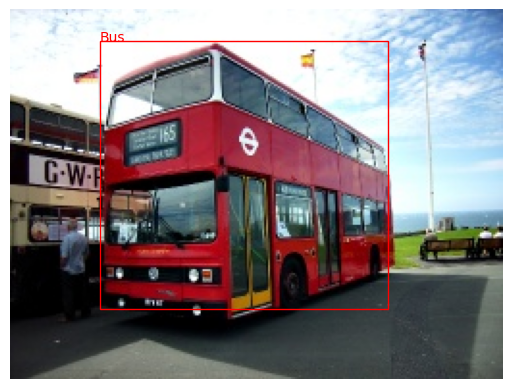

(array([ 46,  16, 196, 155], dtype=uint16), 'Bus', 0.8944413)

In [27]:
frcnn_inference(valid_ds[20][5])